# 09-3 LSTM과 GRU 셀

#### LSTM(Long Short-Term Memory) 
* 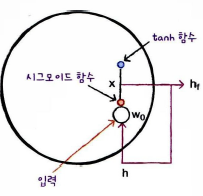
* LSTM은 순환되는 상태가 2개: 은닉상태 + 셀상태(cell state) 
* 은닉상태는 다음 층으로 전달, 셀 상태는 다음 층으로 전달되지 않고 현재 셀 안에서만 순환
* 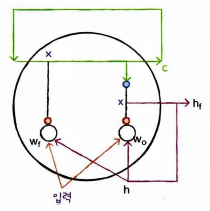
* c: 셀 상태, h: 은닉 상태
* 셀 상태 계산: 입력과 은닉상태(h)를 가중치 Wf에 곱한 다음 시그모이드 함수 통과 -> 이전 타임스텝의 셀 상태과 곱해서 새로운 셀 상태 생성-> tanh(파란색 작은원)함수를 통과하여 새로운 은닉 상태 만드는데 기여
* 입력과 은닉 상태에 곱해지는 가퉁지 Wo와 Wf가 다름 
* 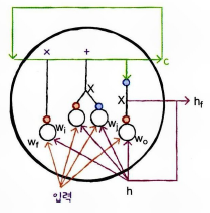
* LSTM에는 총 4개의 작은 셀이 있음
* 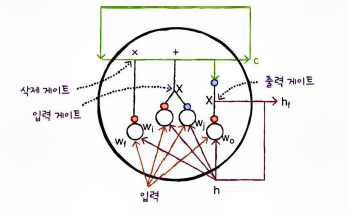
* 삭제게이트: 셀 상태에 있는 정보 제거
* 입력게이트: 새로운 정보를 셀 상태에 추가
* 출력게이트: 이 셀 상태가 다음 은식 상태로 출력

In [18]:

from keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words = 500)

train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [19]:
from keras.preprocessing.sequence import pad_sequences
train_seq  = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [20]:
import keras

model_lstm = keras.Sequential()
model_lstm.add(keras.layers.Input(shape=(100,)))
model_lstm.add(keras.layers.Embedding(500,16))
model_lstm.add(keras.layers.LSTM(8))
model_lstm.add(keras.layers.Dense(1, activation = 'sigmoid'))



In [21]:
model_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from lightgbm import early_stopping


model_lstm.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                   metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model_lstm.fit(train_seq, train_target, epochs=10, batch_size=64,
                         validation_data=(val_seq, val_target),
                         callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.6155 - loss: 0.6492 - val_accuracy: 0.7814 - val_loss: 0.4726
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7852 - loss: 0.4652 - val_accuracy: 0.7818 - val_loss: 0.4553
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.7965 - loss: 0.4350 - val_accuracy: 0.7952 - val_loss: 0.4514
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8103 - loss: 0.4187 - val_accuracy: 0.7970 - val_loss: 0.4492
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8122 - loss: 0.4106 - val_accuracy: 0.8030 - val_loss: 0.4314
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8104 - loss: 0.4042 - val_accuracy: 0.8046 - val_loss: 0.4285
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8229 - loss: 0.3876 - val_accuracy: 0.7904 - val_loss: 0.4379
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8229 - loss: 0.3860 - val_accu

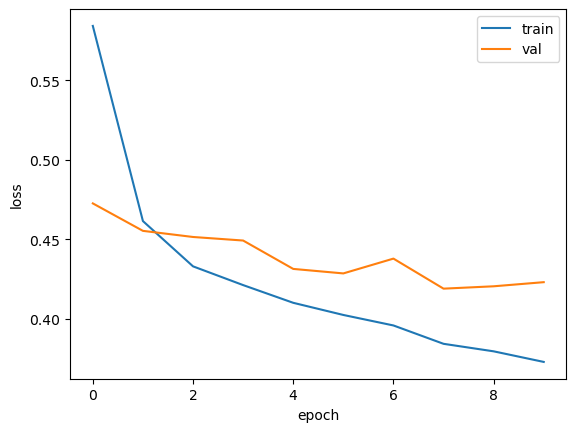

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label ='train')
plt.plot(history.history['val_loss'], label = 'val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [24]:
# 순환층에 드롭아웃 적용하기 

from torch import dropout


model_dropout = keras.Sequential()
model_dropout.add(keras.layers.Input(shape=(100,)))
model_dropout.add(keras.layers.Embedding(500, 16))
model_dropout.add(keras.layers.LSTM(8, dropout=0.2))
model_dropout.add(keras.layers.Dense(1, activation= 'sigmoid'))

In [25]:
model_dropout.compile(optimizer='adam', loss ='binary_crossentropy',
                      metrics= ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model_dropout.fit(train_seq, train_target, epochs=100, batch_size= 64,
                            validation_data=(val_seq, val_target),
                            callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.5977 - loss: 0.6609 - val_accuracy: 0.7682 - val_loss: 0.5007
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7738 - loss: 0.4806 - val_accuracy: 0.7718 - val_loss: 0.4696
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.7940 - loss: 0.4441 - val_accuracy: 0.7926 - val_loss: 0.4439
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8023 - loss: 0.4208 - val_accuracy: 0.8062 - val_loss: 0.4246
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8120 - loss: 0.4087 - val_accuracy: 0.8000 - val_loss: 0.4320
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8206 - loss: 0.3979 - val_accuracy: 0.8080 - val_loss: 0.4199
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8127 - loss: 0.3990 - val_accuracy: 0.8046 - val_loss: 0.4255
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8250 - loss: 0.3860 -

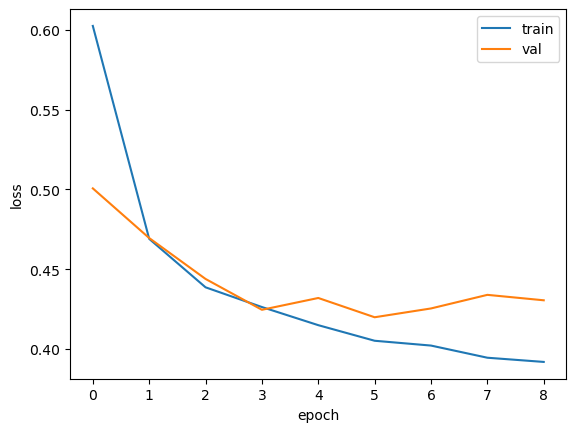

In [26]:
plt.plot(history.history['loss'], label ='train')
plt.plot(history.history['val_loss'], label = 'val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# 두개의 층을 연결하기 

model_21stm = keras.Sequential()
model_21stm.add(keras.layers.Input(shape=(100,)))
model_21stm.add(keras.layers.Embedding(500, 16))
model_21stm.add(keras.layers.LSTM(8, dropout=0.2, return_sequences=True))
model_21stm.add(keras.layers.LSTM(8, dropout=0.2))
model_21stm.add(keras.layers.Dense(1, activation='sigmoid'))
model_21stm.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100, 8)         │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,353 (36.54 KB)

 Trainable params: 9,353 (36.54 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model_21stm.compile(optimizer='adam', loss ='binary_crossentropy',
                      metrics= ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-21stm-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model_21stm.fit(train_seq, train_target, epochs=100, batch_size= 64,
                            validation_data=(val_seq, val_target),
                            callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.6068 - loss: 0.6499 - val_accuracy: 0.7676 - val_loss: 0.4959
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.7722 - loss: 0.4907 - val_accuracy: 0.7746 - val_loss: 0.4836
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.7954 - loss: 0.4519 - val_accuracy: 0.7950 - val_loss: 0.4399
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.8086 - loss: 0.4275 - val_accuracy: 0.8070 - val_loss: 0.4269
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.8013 - loss: 0.4314 - val_accuracy: 0.7966 - val_loss: 0.4378
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.8119 - loss: 0.4117 - val_accuracy: 0.8024 - val_loss: 0.4239
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8188 - loss: 0.4051 - val_accuracy: 0.8098 - val_loss: 0.4176
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8217 - loss: 0

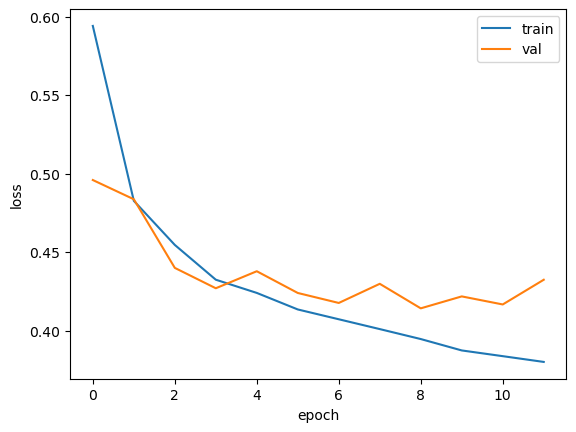

In [29]:
plt.plot(history.history['loss'], label ='train')
plt.plot(history.history['val_loss'], label = 'val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

#### GRU 구조 : LSTM 간소화 버전
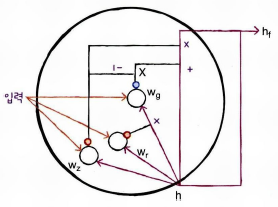


In [30]:
model_gru = keras.Sequential()
model_gru.add(keras.layers.Input(shape = (100,)))
model_gru.add(keras.layers.Embedding(500, 16))
model_gru.add(keras.layers.GRU(8, dropout = 0.2))
model_gru.add(keras.layers.Dense(1, activation='sigmoid'))

In [31]:
model_gru.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 8)              │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,633 (33.72 KB)

 Trainable params: 8,633 (33.72 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model_gru.compile(optimizer='adam', loss ='binary_crossentropy',
                      metrics= ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model_gru.fit(train_seq, train_target, epochs=100, batch_size= 64,
                            validation_data=(val_seq, val_target),
                            callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.5897 - loss: 0.6630 - val_accuracy: 0.7704 - val_loss: 0.4935
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.7787 - loss: 0.4779 - val_accuracy: 0.7822 - val_loss: 0.4566
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.7862 - loss: 0.4556 - val_accuracy: 0.7674 - val_loss: 0.4921
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.8019 - loss: 0.4338 - val_accuracy: 0.7938 - val_loss: 0.4427
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.8057 - loss: 0.4295 - val_accuracy: 0.8012 - val_loss: 0.4314
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.8102 - loss: 0.4198 - val_accuracy: 0.7990 - val_loss: 0.4350
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8128 - loss: 0.4110 - val_accuracy: 0.7974 - val_loss: 0.4386
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.8097 - loss: 0

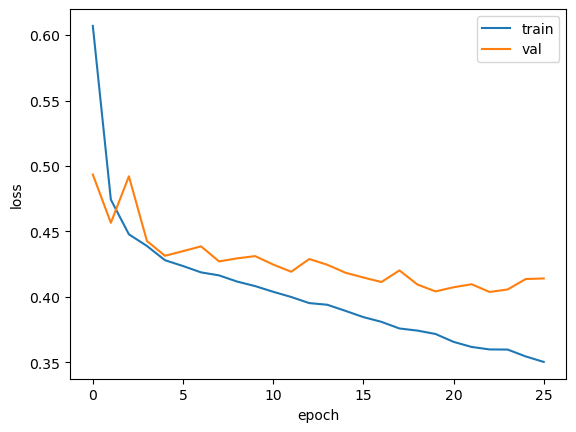

In [33]:
plt.plot(history.history['loss'], label ='train')
plt.plot(history.history['val_loss'], label = 'val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# 테스트세트로 성능확인

test_seq = pad_sequences(test_input, maxlen=100)
best_model = keras.models.load_model('best-gru-model.keras')
best_model.evaluate(test_seq, test_target)

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8186 - loss: 0.3995


[0.39558184146881104, 0.8192399740219116]